# Building and Training a Siamese Face Classification Neural Network

This notebook offers a step-by-step process to build a small face classification neural network. The functions used to create the model are described in detail in our utils notebooks, and the methodology is based on 'Hands-on Meta-learning in Python' https://www.oreilly.com/library/view/hands-on-meta-learning/9781789534207/#:~:text=Hands%2DOn%20Meta%20Learning%20with%20Python%20is%20for%20machine%20learning,and%20Python%20programming%20is%20necessary.

In [13]:
# import libraries and utilities, although we will type out our utility functions in full here to make the process clear
%run "utils_imports.ipynb"
%run "utils_attacks.ipynb"
%run "utils_data.ipynb"
%run "utils_helper.ipynb"
%run "utils_training.ipynb"
%run "siamese_attack_variants.ipynb"

## Creating a paired dataset

First, we take our dataset of 400 face images (10 for each class, meaning 40 classes) and convert it into a paired dataset of 20000 pairs of images, with 10000 true pairs and 10000 false pairs. For more detail on the functions used here, see data_utils.ipynb.

In [18]:
def read_image(filename, byteorder='>'):
    """
    Read an image as a numpy array.
    
    Params:
        String: filename.
        String: byteorder.
        
    Returns:
        np_array.
    """
    #open the image
    with open(filename, 'rb') as f:
        buffer = f.read()
    
    #extract the header, width, height and maxval
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    
    #convert to numpy array
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

def get_face_data(filepath='../data/facesatt',size=2, total_sample_size=10000):
    """
        Retrieve the face dataset. With default params this will return 20000 image pairs.
        
        Params:
            string: filepath.
            int: size.
            int: total_sample_size.
        Returns:
            np_array: X.
            np_array: Y.
    """
    #read the image
    image = read_image(str(filepath)+'/s' + str(1) + '/' + str(1) + '.pgm', 'rw+')
    #reduce the size
    image = image[::size, ::size]
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0
    
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, dim1, dim2, 1])  # 2 is for pairs
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(40):
        for j in range(int(total_sample_size/40)):
            ind1 = 0
            ind2 = 0
            
            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            # read the two images
            img1 = read_image(str(filepath)+'/s' + str(i+1) + '/' + str(ind1 + 1) + '.pgm', 'rw+')
            img2 = read_image(str(filepath)+'/s' + str(i+1) + '/' + str(ind2 + 1) + '.pgm', 'rw+')
            
            #reduce the size
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            #store the images to the initialized numpy array
            x_geuine_pair[count, 0, :, :, 0] = img1
            x_geuine_pair[count, 1, :, :, 0] = img2
            
            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, dim1, dim2, 1])
    y_imposite = np.zeros([total_sample_size, 1])
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            
            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(40)
                ind2 = np.random.randint(40)
                if ind1 != ind2:
                    break
                    
            img1 = read_image(str(filepath)+'/s' + str(ind1+1) + '/' + str(j + 1) + '.pgm', 'rw+')
            img2 = read_image(str(filepath)+'/s' + str(ind2+1) + '/' + str(j + 1) + '.pgm', 'rw+')

            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]

            x_imposite_pair[count, 0, :, :, 0] = img1
            x_imposite_pair[count, 1, :, :, 0] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1
            
    #now, concatenate, genuine pairs and imposite pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

def preprocess_image(image, size):
    image = image[::size, ::size]
    
    return image

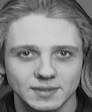

In [19]:
Image.open("../data/facesatt/s12/1.pgm") #visualise data

In [20]:
img = read_image('../data/facesatt/s12/1.pgm')
img.shape #shape of data

(112, 92)

Once we get our paired dataset, we can see the shape, with 20000 pairs of resized images.

In [22]:
X, Y = get_face_data()

In [23]:
X.shape

(20000, 2, 56, 46, 1)

In [24]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25) #convert the dataset into a train-test split

## Building the model

Firstly, we build two identical feature extractor CNNs and then we combine them together in the final siamese architecture.

In [25]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)
print(input_dim)

(56, 46, 1)


In [26]:
def make_embedding_layer(input_shape): 
    # in this function, we create our base feature extractor CNN
    
    model = Sequential([
        Input(shape=input_shape, name='input_image'),
        Conv2D(6, (3,3), data_format='channels_last', activation='relu'), # First block
        MaxPooling2D(pool_size=(2,2), padding='same'),
        Conv2D(12, (3,3), data_format='channels_last', activation='relu'), # Second block
        MaxPooling2D(64, (2,2), padding='same'),
        Flatten(),
        Dense(128, activation='relu'),
    ], name = 'embedding')
    
    
    return model

In [27]:
# we then create two identical feature extractor CNNs
base_network = make_embedding_layer(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

In [28]:
# these helper functions calculate the euclidean distance between two sets of vectors, which will be our distance function
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [29]:
# establishing our distance function
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

In [30]:
model = Model(inputs=[img_a, img_b], outputs=distance) #combining the feature extractors and the distance layer into one model

In [31]:
epochs = 16 #establishing some training metrics
rms = RMSprop()

In [32]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', # we use early stopping to avoid overfitting
                              min_delta=0,
                              patience=3,
                              verbose=1,
                              restore_best_weights=True)
callback_early_stop_reduceLROnPlateau=[earlyStopping]

In [33]:
def contrastive_loss(y_true, y_pred):
    # here we define our loss function, contrastive loss
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [34]:
def accuracy(y_true, y_pred): # here we define our accuracy metric to measure performance
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [35]:
model.compile(loss=contrastive_loss, optimizer=rms,metrics=[accuracy])
model.summary() #finally, we compile the model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 56, 46, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 56, 46, 1)]  0           []                               
                                                                                                  
 embedding (Sequential)         (None, 128)          200528      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['embedding[0][0]',          

In [36]:
def make_model(input_dim, img_a, img_b):
    # this is a function that combines all the work we did above into a single function
    base_network = make_embedding_layer(input_dim)
    feat_vecs_a = base_network(img_a)
    feat_vecs_b = base_network(img_b)
    
    distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])
    
    model = Model(inputs=[img_a, img_b], outputs=distance)
    
    epochs = 16
    rms = RMSprop()
    
    model.compile(loss=contrastive_loss, optimizer=rms,metrics=[accuracy])
    
    return model
model2 = make_model(input_dim, img_a, img_b)
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 56, 46, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 56, 46, 1)]  0           []                               
                                                                                                  
 embedding (Sequential)         (None, 128)          200528      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 1)            0           ['embedding[0][0]',        

## Training the model

Now, we train our model on the paired dataset.

In [37]:
img_1 = x_train[:, 0] #split the paired dataset into two lists
img2 = x_train[:, 1]

In [35]:
# train the model
model.fit([img_1, img2], y_train, validation_split=.25,
          batch_size=128, verbose=2, epochs=epochs, callbacks=callback_early_stop_reduceLROnPlateau)

Epoch 1/16
88/88 - 25s - loss: 0.1462 - accuracy: 0.8139 - val_loss: 0.1189 - val_accuracy: 0.8566 - 25s/epoch - 287ms/step
Epoch 2/16
88/88 - 23s - loss: 0.1063 - accuracy: 0.8769 - val_loss: 0.0988 - val_accuracy: 0.8867 - 23s/epoch - 256ms/step
Epoch 3/16
88/88 - 23s - loss: 0.0920 - accuracy: 0.9005 - val_loss: 0.0924 - val_accuracy: 0.9066 - 23s/epoch - 258ms/step
Epoch 4/16
88/88 - 35s - loss: 0.0836 - accuracy: 0.9151 - val_loss: 0.0834 - val_accuracy: 0.9172 - 35s/epoch - 400ms/step
Epoch 5/16
88/88 - 47s - loss: 0.0771 - accuracy: 0.9267 - val_loss: 0.0771 - val_accuracy: 0.9285 - 47s/epoch - 534ms/step
Epoch 6/16
88/88 - 47s - loss: 0.0727 - accuracy: 0.9375 - val_loss: 0.0730 - val_accuracy: 0.9300 - 47s/epoch - 531ms/step
Epoch 7/16
88/88 - 47s - loss: 0.0684 - accuracy: 0.9404 - val_loss: 0.0695 - val_accuracy: 0.9404 - 47s/epoch - 535ms/step
Epoch 8/16
88/88 - 48s - loss: 0.0651 - accuracy: 0.9448 - val_loss: 0.0671 - val_accuracy: 0.9404 - 48s/epoch - 549ms/step
Epoch 9/

In [36]:
pred = model.predict([x_test[:, 0], x_test[:, 1]]) #generate predictions

In [37]:
def compute_accuracy(predictions, labels): #calculate accuracy
    return labels[predictions.ravel() < 0.5].mean()

## Evaluation

As we can see, the model performs well on test data, with over 90% accuracy despite the small initial dataset.

In [38]:
compute_accuracy(pred, y_test)

0.9366895499618612

In [44]:
model.save_weights('../models/face_siamese_weights/siamesefacepredictorweights.h5')

In [45]:
model.load_weights('../models/face_siamese_weights/siamesefacepredictorweights.h5')

## Visualisation

Below, we visualise the performance of our new model.

In [46]:
import matplotlib.pyplot as plt

In [47]:
def plot_example(num=0):
    # plot a pair of images from the dataset, the true label, and the prediction of the model
    
    # Set plot size 
    plt.figure(figsize=(10,8))


    # Set first subplot
    plt.subplot(1,2,1)
    
    img1 = x_test[num, 0]
    img2 = x_test[num, 1]

    plt.imshow(img1, cmap='gray')

    # Set second subplot
    plt.subplot(1,2,2)
    plt.imshow(img2, cmap='gray')

    # Renders cleanly
    plt.show()

    if pred[num] < 0.5:
        print("Positive match")
    else:
        print("Negative match")

    print("Distance between faces: ",pred[num])

In [48]:
def plot_specific_example(input_image, validation_image, pred):
    # same as above, but for a specific example
    
    # Set plot size 
    plt.figure(figsize=(10,8))


    # Set first subplot
    plt.subplot(1,2,1)
    
    img1 = input_image
    img2 = validation_image

    plt.imshow(img1, cmap='gray')

    # Set second subplot
    plt.subplot(1,2,2)
    plt.imshow(img2, cmap='gray')

    # Renders cleanly
    plt.show()

    if pred < 0.5:
        print("Positive match")
    else:
        print("Negative match")

    print("Distance between faces: ",pred)

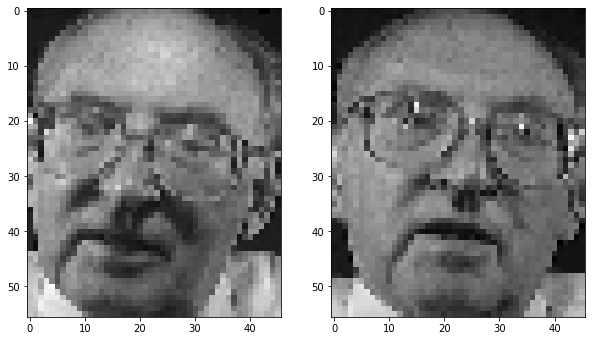

Positive match
Distance between faces:  [0.2348757]


In [49]:
plot_example()

In [50]:
def plot_examples(num_examples = 1, example_range = 5000):
    #plot many examples
    
    for i in range(num_examples):
        num = np.random.randint(example_range)
        plot_example(num)

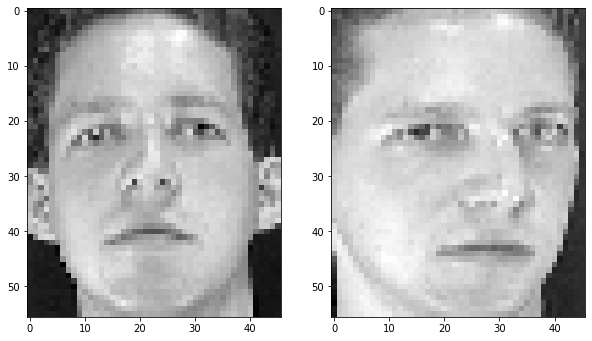

Positive match
Distance between faces:  [0.38386205]


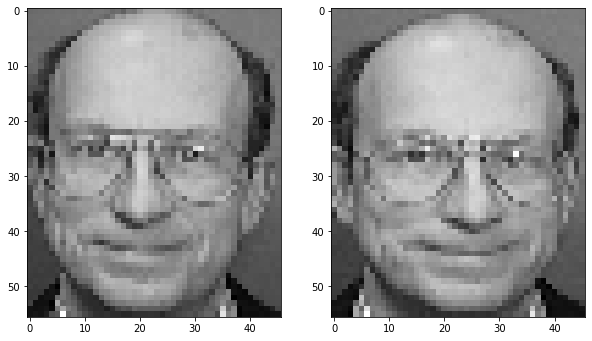

Positive match
Distance between faces:  [0.2121091]


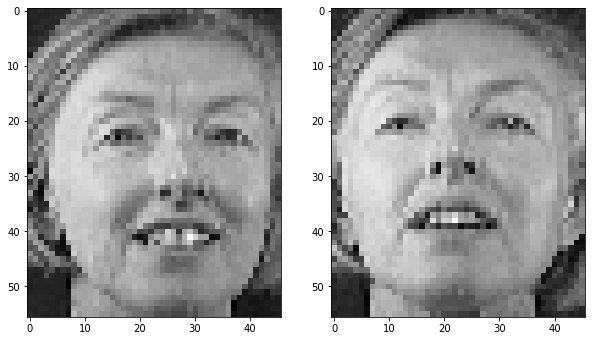

Positive match
Distance between faces:  [0.12732795]


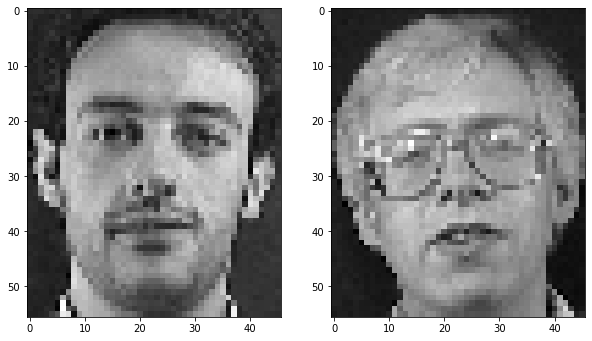

Negative match
Distance between faces:  [0.77964044]


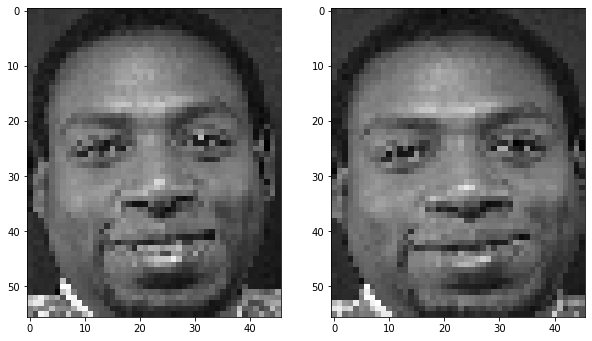

Positive match
Distance between faces:  [0.17683887]


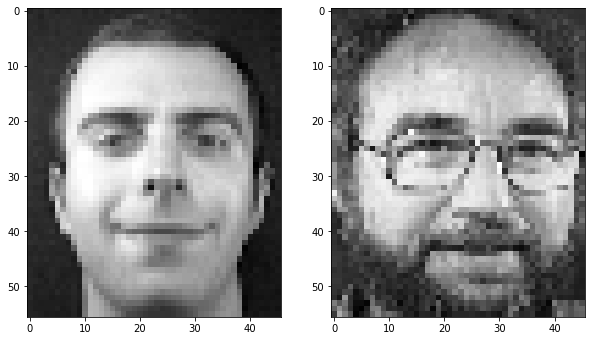

Negative match
Distance between faces:  [0.9657563]


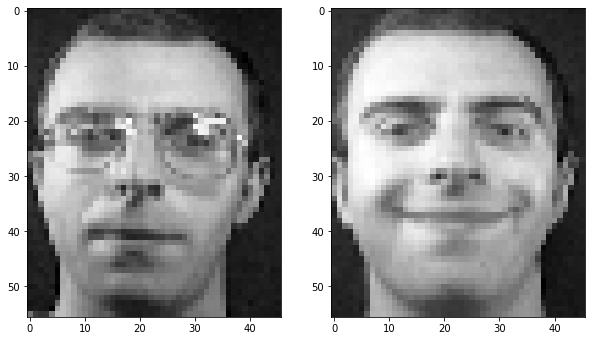

Positive match
Distance between faces:  [0.23143911]


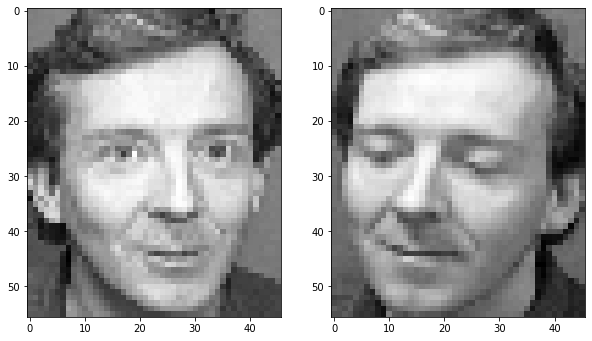

Positive match
Distance between faces:  [0.15024553]


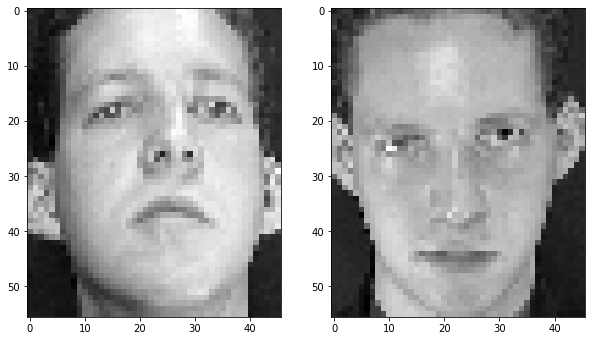

Positive match
Distance between faces:  [0.04425419]


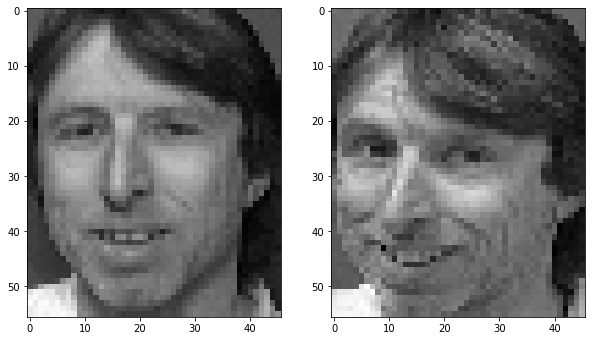

Positive match
Distance between faces:  [0.30226964]


In [51]:
plot_examples(10)